In [1]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agent

import torch
from collections import deque
import matplotlib.pyplot as plt

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [3]:
def ddpg(num_episodes=1000):
    score_deque = deque(maxlen=100)
    score_list = []
    agent_list = []
    
    for i in range(num_agents):
        agent_list.append(Agent(state_size, action_size,num_agents , random_seed=0))

    for episodes in range(1, num_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        for agent in agent_list:
            agent.reset()
        scores = np.zeros(num_agents)
        timestep = 0
        while True:
            actions = [agent_list[i].act(states[i]) for i in range(num_agents)]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            done = env_info.local_done
            
            for i in range(num_agents):
                agent_list[i].step(timestep, states[i], actions[i], rewards[i],next_states[i], done[i])

            states = next_states
            scores += rewards
            print('\rEpisode {}\tTimestep {}\tRewards {}\tScores: {}'
                  .format(episodes, timestep, np.array(rewards), scores), end="")
            if np.any(done):
                break
            timestep += 1

        score_deque.append(np.max(scores))
        score_list.append(np.max(scores))

        print(
            '\rEpisode {}\tAverage Score Last 100 Episodes: {:.5f}\tMax Score (All Agents) Last Episode: {:.2f}'.format(
                episodes, np.mean(score_deque), np.amax(scores)), end="")
        if episodes % 100 == 0:
            print('\rEpisode {}\tAverage Score Last 100 Episodes: {:.5f}'.format(episodes, np.mean(score_deque)))
        if np.mean(score_deque) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.5f}'.format(episodes - 100,
                                                                                         np.mean(score_deque)))
            torch.save(agent_list[0].actor_local.state_dict(), 'actor_0.pth')
            torch.save(agent_list[1].actor_local.state_dict(), 'actor_1.pth')
            torch.save(Agent.critic_local.state_dict(), 'critic.pth')
            break
    return score_list

Episode 100	Average Score Last 100 Episodes: 0.04650	Max Score (All Agents) Last Episode: 0.10
Episode 200	Average Score Last 100 Episodes: 0.12750	Max Score (All Agents) Last Episode: 0.10
Episode 265	Average Score Last 100 Episodes: 0.50800	Max Score (All Agents) Last Episode: 2.10
Environment solved in 165 episodes!	Average Score: 0.50800


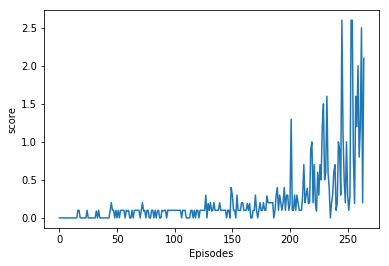

In [4]:
score = ddpg()

fig = plt.figure()
plt.plot(np.arange(len(score)), score)
plt.ylabel('score')
plt.xlabel('Episodes')
plt.show()